# Plotting GINI Satellite Data with MetPy and Siphon

## Objectives:
1. Get introduced to using Siphon to talk to the THREDDS data server
2. Learn how to open remote files on the data server using Python
3. Open GINI files using MetPy
4. Plot using CartoPy

### Additional resources
- [MetPy Documentation](http://metpy.readthedocs.org)
- [Siphon Documentation](http://siphon.readthedocs.org)

## Getting the data file

The first step is to find the satellite data. If we browse over to http://thredds.ucar.edu/thredds/, we're presented with the top-level [TDS](https://www.unidata.ucar.edu/software/thredds/current/tds/TDS.html) catalog; this has a helpful looking link that says "Satellite Data". Navigating here, we see a large collection of different satellite datasets. We're interested in looking at water vapor imagery, so the "Water Vapor (6.5 / 5.7 um)" link seems most useful. We'll dig further in by navigating into "EAST-CONUS_4km" and then "current", so that we can look at current full CONUS (CONtiguous US) images from GOES East.

Here, we find a large listing of individual files. We could manually download a file and open it, but:
1. That's no fun whatsoever
2. It means we'd have to go through the same manual process to get data tomorrow

Instead, Python to the rescue! We can use Unidata's Siphon package to parse the catalog from the TDS; this provides us a nice programmatic way of accesssing the data. So we start by importing the `TDSCatalog` class from siphon and giving it the URL to the catalog we just surfed to manually.

**Note:** Instead of giving it the link to the HTML catalog, we change the extension to XML, which asks the TDS for the XML version of the catalog. This is much better to work with in code.

In [1]:
from siphon.catalog import TDSCatalog
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/satellite/WV/EAST-CONUS_4km/current/catalog.xml')

From this `TDSCatalog` object we now have (`cat`), and we want to get the latest file. To find the latest file, we can look at the `cat.datasets` attribute. This is a Python dictionary, mapping the name of the dataset to a Python Dataset object (which came from more XML supplied by the TDS &mdash; notice a theme?) Since this is a dictionary, we can look at a list of the keys (or actually, just the first 5):

In [2]:
list(cat.datasets)[:5]

['EAST-CONUS_4km_WV_20160406_1515.gini',
 'EAST-CONUS_4km_WV_20160406_1445.gini',
 'EAST-CONUS_4km_WV_20160406_1437.gini',
 'EAST-CONUS_4km_WV_20160406_1430.gini',
 'EAST-CONUS_4km_WV_20160406_1425.gini']

Now what we really want is the most recent file, which is the first one in the list. We can pull that out, and use its name to get the actual Python `Dataset` object:

In [3]:
dataset_name = list(cat.datasets)[0]
dataset = cat.datasets[dataset_name]
print(dataset)

The `catalog.Dataset` class provides access to a lot of information about a dataset, like metadata (e.g. time range, spatial extent). What we want most however, is to know how to access the data. This is provided by the `dataset.access_urls` attribute:

In [4]:
dataset.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20160406_1515.gini',
 'HTTPServer': 'http://thredds.ucar.edu/thredds/fileServer/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20160406_1515.gini',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20160406_1515.gini',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20160406_1515.gini',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20160406_1515.gini',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20160406_1515.gini',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20160406_1515.gini',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20160406_1515.g

These different urls provide access to the data in different ways; some support different protocols (like OPeNDAP or CDMRemote), others allow harvesting metadata (e.g. ISO). We're going to start simple, so we want to use the `HTTPServer` method, which allows downloading the datafile using HTTP. (Other data access methods will be the subject of future posts.) We can take this URL and pass it to the `urlopen` function from the `urllib.request` module in Python's standard library. This gives us a Python file-like object, which for the most part we can treat just like a file we opened locally.

In [5]:
from urllib.request import urlopen
remote_gini_file = urlopen(dataset.access_urls['HTTPServer'])

## Parsing the data

Now that we have this file-like object, we could certainly `read()` data and parse it by hand or save to disk, but that's too much work. Instead, we will use MetPy's support for reading GINI files by importing the `GiniFile` class, and passing it the file-like object:

In [6]:
from metpy.io.gini import GiniFile
gini = GiniFile(remote_gini_file)
print(gini)

GiniFile: GOES-13 East CONUS WV (6.5/6.7 micron)
	Time: 2016-04-06 15:15:18
	Size: 1280x1280
	Projection: lambert_conformal
	Lower Left Corner (Lon, Lat): (-113.1333, 16.3691)
	Resolution: 4km


`GiniFile` was able to successfully parse the data and we see (as expected) that we have a 4km CONUS water vapor image from GOES-13 East. While `GiniFile` itself provides a low-level interface to all the information in the file (useful if checking to see if the file was parsed correctly), we don't need the low level details. Fortunately, the `to_dataset()` method can convert the data into a form that resembles the `Dataset` object from [netCDF4-python](https://unidata.github.io/netcdf4-python/).

In [7]:
gini_ds = gini.to_dataset()
print(gini_ds)

root

Dimensions:
<class 'metpy.io.cdm.Dimension'>: name = time, size = 1
<class 'metpy.io.cdm.Dimension'>: name = x, size = 1280
<class 'metpy.io.cdm.Dimension'>: name = y, size = 1280

Variables:
<class 'metpy.io.cdm.Variable'>: int32 time(time)
	units: milliseconds since 2016-04-06T00:00:00
	shape = 1
<class 'metpy.io.cdm.Variable'>: int32 Lambert_Conformal()
	grid_mapping_name: lambert_conformal_conic
	standard_parallel: 25.0
	longitude_of_central_meridian: -95.0
	latitude_of_projection_origin: 25.0
	earth_radius: 6371200.0
<class 'metpy.io.cdm.Variable'>: float64 x(x)
	units: m
	long_name: x coordinate of projection
	standard_name: projection_x_coordinate
	shape = 1280
<class 'metpy.io.cdm.Variable'>: float64 y(y)
	units: m
	long_name: y coordinate of projection
	standard_name: projection_y_coordinate
	shape = 1280
<class 'metpy.io.cdm.Variable'>: float64 lon(y, x)
	long_name: longitude
	units: degrees_east
	shape = (1280, 1280)
<class 'metpy.io.cdm.Variable'>: float64 lat(y, x)
	

Or, we can take the `gini_ds.variables` attribute, which is a dictionary, and convert it to a Python list (using `list`); this will pull all of the keys out of the dictionary:

In [8]:
list(gini_ds.variables)

['time', 'Lambert_Conformal', 'x', 'y', 'lon', 'lat', 'WV']

## Grabbing data from the file
Our goal is to plot water vapor imagery, so we're going to ask for `WV` from the `.variables` dictionary.
Rather than just giving back the raw array of data, this gives back a `Variable` object; from here not only
can we get the raw data values, but there is useful metadata as well. We can see just what additional information
is present by printing out the `Variable` object:

In [9]:
data_var = gini_ds.variables['WV']
print(data_var)

<class 'metpy.io.cdm.Variable'>: uint8 WV(y, x)
	long_name: WV (6.5/6.7 micron)
	missing_value: 255
	coordinates: y x
	grid_mapping: Lambert_Conformal
	shape = (1280, 1280)


This reveals several useful pieces of information (such as a longer description of the variable), but we're going to focus on two particular attributes: `coordinates` and `grid_mapping`. These two attributes are defined by the [NetCDF Climate and Forecast (CF) Metadata Conventions](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html). The `coordinates` attribute specifies what other variables are needed to reference the variable in time and space; the `grid_mapping` attribute specifies a variable that contains information about the grid's projection.

This tells us that we need to grab the data from the `x` and `y` variable objects for plotting. We use an empty slice (`[:]`) to copy the actual numeric values out of the variables (for easier use with matplotlib and cartopy).

In [10]:
x = gini_ds.variables['x'][:]
y = gini_ds.variables['y'][:]

We also then grab the variable corresponding to the `grid_mapping` attribute so that we can have a look at the projection information. Rather than hard coding the name of the variable (in this case `Lambert_Conformal`), we just directly pass the `grid_mapping` attribute to the `.variables` dictionary; this makes it easier to re-use the code in the future with different data.

In [11]:
proj_var = gini_ds.variables[data_var.grid_mapping]
print(proj_var)

<class 'metpy.io.cdm.Variable'>: int32 Lambert_Conformal()
	grid_mapping_name: lambert_conformal_conic
	standard_parallel: 25.0
	longitude_of_central_meridian: -95.0
	latitude_of_projection_origin: 25.0
	earth_radius: 6371200.0


This shows that the projection is Lambert conformal; the variable also includes a few parameters (such as the latitude and longitude of the origin) needed to properly set up the projection to match what was used to create the image. This variable also has information about the assumed shape of the earth, which in this case is spherical with a radius of 6371.2 km.

### Exercise: Go grab some data on your own
1. Open a web browser and pick out a [satellite dataset](http://thredds.ucar.edu/thredds/idd/satellite.html)
2. Crawl down into the dataset directory (i.e. one with a whole bunch of `.gini` files); this can be current or data from some past available data that you find interesting
3. Grab the URL and pass to `TDSCatalog`
4. Using the `TDSCatalog` API as well as `GINIFile`, open a particular gini file and look at the projection information (like `Lambert_Conformal` above)

## Setting up the projection

The first step to use this information for plotting is to import Cartopy's `crs` (Coordinate Reference System) module; from this module we create a `Globe` object that allows us to encode the assumed shape and size of the earth:

In [12]:
import cartopy.crs as ccrs

# Create a Globe specifying a spherical earth with the correct radius
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.earth_radius,
                   semiminor_axis=proj_var.earth_radius)

From here, we use the `LambertConformal` class to create a Lambert conformal projection with all of the attributes that were specified in the file. We also include the `Globe` object we created.

In [13]:
proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                             central_latitude=proj_var.latitude_of_projection_origin,
                             standard_parallels=[proj_var.standard_parallel],
                             globe=globe)

## Plotting with CartoPy

Now that we know how to properly reference the imagery data (using the `LambertConformal` projection object), we can plot
the data. CartoPy's projections are designed to interface with matplotlib, so they can just be passed as the `projection` keyword argument when creating an `Axes` using the `add_subplot` method. Since the x and y coordinates, as well as the image data, are referenced in the lambert conformal projection, so we can pass all of them in directly to plotting methods (such as `imshow`) with no additional information. The `extent` keyword argument to `imshow` is used to specify the bounds of the image data being plotted.

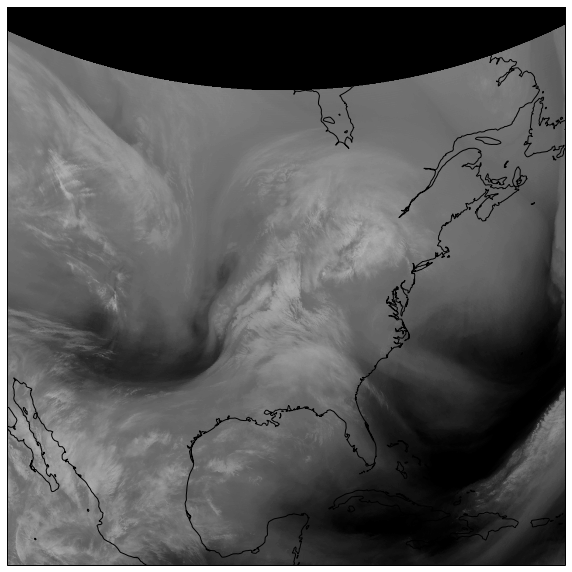

In [14]:
# Make sure the notebook puts figures inline
%matplotlib inline
import matplotlib.pyplot as plt

# Create a new figure with size 10" by 10"
fig = plt.figure(figsize=(10, 10))

# Put a single axes on this figure; set the projection for the axes to be our
# Lambert conformal projection
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the data using a simple greyscale colormap (with black for low values);
# set the colormap to extend over a range of values from 140 to 255.
# Note, we save the image returned by imshow for later...
im = ax.imshow(data_var[:], extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
               cmap='Greys_r', norm=plt.Normalize(140, 255))

# Add high-resolution coastlines to the plot
ax.coastlines(resolution='50m', color='black')

This is a nice start, but it would be nice to have better geographic references for the image. Fortunately, Cartopy's `feature` module has support for adding geographic features to plots. Many features are built in; for instance, the `BORDERS` built-in feature contains country borders. There is also support for creating "custom" features from the [Natural Earth](http://www.naturalearthdata.com/) set of free vector and raster map data; CartoPy will automatically download the necessary data and cache it locally. Here we create a feature for states/provinces.

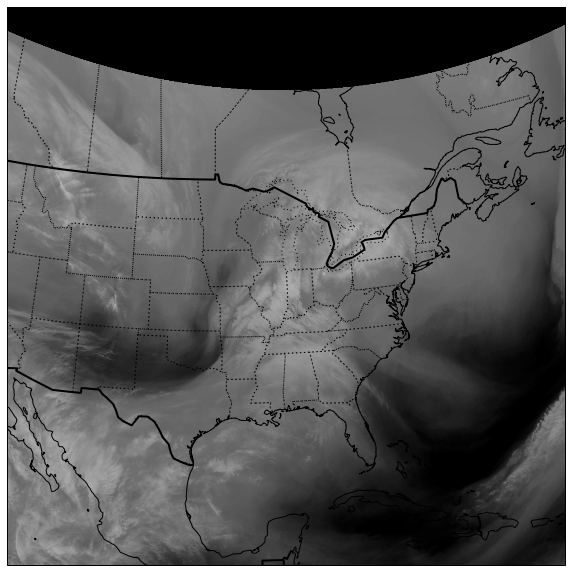

In [15]:
import cartopy.feature as cfeat

# Add country borders with a thick line.
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

# Set up a feature for the state/province lines. Tell cartopy not to fill in the polygons
state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lakes',
                                             scale='50m', facecolor='none')

# Add the feature with dotted lines, denoted by ':'
ax.add_feature(state_boundaries, linestyle=':')

# Redisplay modified figure
fig

The map is much improved now; but it would look so much better in color! Let's play with the colormapping of the imagery a little...

Colormapping in matplotlib (which backs CartoPy) is handled through two pieces:

- The colormap controls how values are converted from floating point values in the range [0, 1] to colors (think colortable)
- The norm (normalization) controls how data values are converted to floating point values in the range [0, 1]

We import the `ColortableRegistry` from Metpy's `metpy.plots.ctables` module. This registry provides access to the wide array of colormaps available in MetPy. It also provides convenience methods to grab a colormap (`wv_cmap`) along with a `Normalization` instance (`wv_norm`) appropriate to the number of colors in the colortable. The code below asks for the `WVCIMSS` colormap (converted from GEMPAK), along with a normalization that starts at 0 and increases by a value of 1 for each color in the table.

In [16]:
from metpy.plots.ctables import registry
wv_norm, wv_cmap = registry.get_with_steps('WVCIMSS', 0, 1)

Now we can use the `im` object we saved earlier and reset the cmap and norm on the image to the new ones:

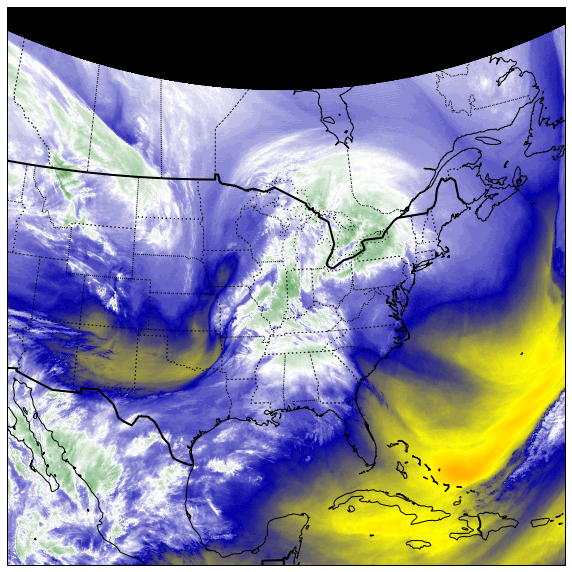

In [17]:
im.set_cmap(wv_cmap)
im.set_norm(wv_norm)
fig

One more thing that would be nice is putting the date and time on the image, so let's do that. First grab the `time` variable from the file:

In [18]:
time_var = gini_ds.variables['time']
print(time_var)

<class 'metpy.io.cdm.Variable'>: int32 time(time)
	units: milliseconds since 2016-04-06T00:00:00
	shape = 1


So we have a variable with a single time, expressed as a count of milliseconds since a reference time. We could parse this manually easily enough, but the netcdf4-python package has this already covered with its `num2date` function, so why rewrite it? We just need to import it and pass it the values (throwing them into `squeeze()` to remove all the extra dimensions) and units:

In [19]:
from netCDF4 import num2date
timestamp = num2date(time_var[:].squeeze(), time_var.units)
timestamp

datetime.datetime(2016, 4, 6, 15, 15, 18)

Great! A sensible time object to work with. Let's add it to our plot.

We use the `text` method to draw text on our plot. In this case, we call it with a `transform` keyword argument, which allows us to tell matplotlib how to interpret the x and y coordinates. In this case, we set the transfrom to `ax.transAxes`, which means "interpret x and y as being in axes space"; axes space has x and y in the range [0, 1] across the entire plotting area (e.g. (0, 0) is lower left, (1, 1) is upper right). Using this, we can put text in the lower right corner (`x = 0.99`, `y = 0.01`) regardless of the range of x and y (or longitude and latitude) in the plot. We also need to make sure to right-align the text so that the text *ends* at the specified point.

We use the `strftime` method to format the datetime as a string. The details of that format string are described [here](https://docs.python.org/3.5/library/datetime.html#strftime-strptime-behavior).

The code below uses matplotlib's [path effects](http://matplotlib.org/users/patheffects_guide.html) to make the text have an outline effect as well. We won't go into detail on that here, so see the linked
[documentation](http://matplotlib.org/users/patheffects_guide.html) for more information.

For completeness, the code below replicates the entirety of the plotting code from above.

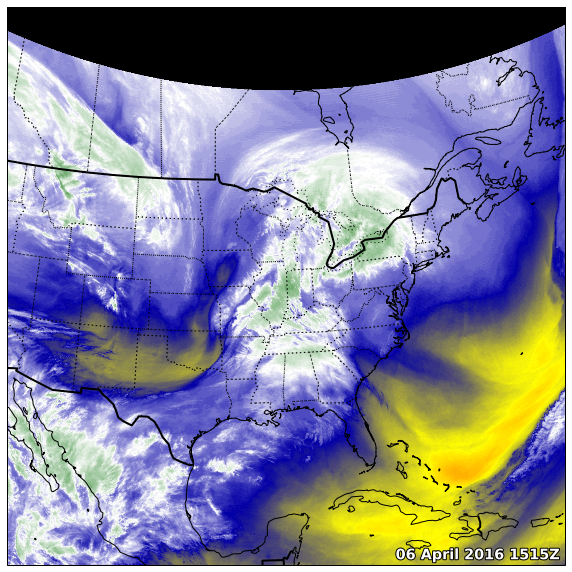

In [20]:
# Same as before, except we call imshow with our colormap and norm.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

im = ax.imshow(data_var[:], extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
               cmap=wv_cmap, norm=wv_norm)
ax.coastlines(resolution='50m', color='black')
ax.add_feature(state_boundaries, linestyle=':')
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

# Add text (aligned to the right); save the returned object so we can manipulate it.
text = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
               horizontalalignment='right', transform=ax.transAxes,
               color='white', fontsize='x-large', weight='bold')

# Make the text stand out even better using matplotlib's path effects
from matplotlib import patheffects
text.set_path_effects([patheffects.Stroke(linewidth=2, foreground='black'),
                       patheffects.Normal()])

### Exercise: Now plot your data

Using the data you retrieved earlier (or some other gini data if you're so inclined):

1. Set-up the CartoPy projection for plotting
2. Create a matplotlib plot for the data (using `imshow`, `contour`, or `contourf`)
3. Improve on the defaults:
   - Change the colormap
   - Change the range of values (by changing the norm)
   - Add a timestamp to the image
   - Or add some more mapping features (See the [cartopy gallery](http://scitools.org.uk/cartopy/docs/latest/gallery.html))

## Bonus: Animations

**NOTE:**
This is just a quick taste of producing an animation using matplotlib. The animation support in matplotlib is solid, but sometimes installation of the underlying tools (mencoder/ffmpeg) can be a little tricky. In order to make sure we get don't get bogged down, this is really more of a demo than something expected to work out of the box.

For windows builds, you might try:
- For [ffmpeg](https://ffmpeg.zeranoe.com/builds/)
- For [mencoder](https://www.mplayerhq.hu/design7/dload.html)

On OSX and linux, conda-forge has packages, so it may be as easy as:

In [21]:
#!conda install -n unidata-workshop -c http://anaconda.org/conda-forge ffmpeg

First we'll import the animation support from matplotlib. We also tell it that we want it to render the animations to HTML using the HTML5 video tag:

In [22]:
import os.path
import sys
from matplotlib import rcParams
#rcParams['animation.html'] = 'html5'
# This line should be uncommented only if ffmpeg was installed using conda above
#rcParams['animation.ffmpeg_path'] = os.path.join(sys.prefix, 'bin', 'ffmpeg')
from matplotlib.animation import ArtistAnimation

Then we create an empty figure which will serve as the basis for all of the frames of the animation:

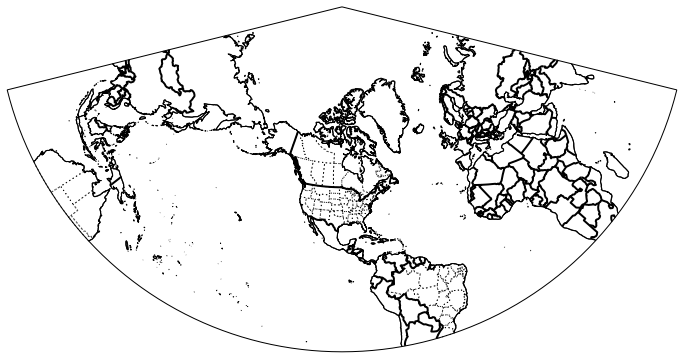

In [23]:
fig = plt.figure(figsize=(12, 12), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines(zorder=2)
ax.coastlines(resolution='50m', color='black')
ax.add_feature(state_boundaries, linestyle=':')
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

Then we loop over a bunch of the datasets. For each one we pull out the data and plot both the timestamp and the image. The `ArtistAnimation` class takes the `Figure` instance and a list as required arguments. The contents of this list is a collection of matplotlib artists for each frame of the animation. In the loop below, we populate this list with the `Text` instance created when adding the timestamp as well as the image that results from plotting the data.

In [24]:
# List used to store the contents of all frames. Each item in the list is a tuple of
# (image, text)
artists = []

# Loop over the last 20 satellite images in the catalog
for ds in list(cat.datasets.values())[:-21:-1]:

    # Open the data using the HTTPServer access url and pass to GINIFile. Then convert
    # it to a netcdf-like dataset
    gini_data = GiniFile(urlopen(ds.access_urls['HTTPServer']))
    nc = gini_data.to_dataset()

    # Pull out the image data, x and y coordinates, and the time. Also go ahead and
    # convert the time to a python datetime
    x = nc.variables['x'][:]
    y = nc.variables['y'][:]
    time_var = nc.variables['time']
    timestamp = num2date(time_var[:].squeeze(), time_var.units)
    img_data = nc.variables['WV'][:]

    # Plot the image and the timestamp. We save the results of these plotting functions
    # so that we can tell the animation that these two things should be drawn as one
    # frame in the animation
    im = ax.imshow(img_data, extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
                   cmap=wv_cmap, norm=wv_norm)
    text = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
                   horizontalalignment='right', transform=ax.transAxes,
                   color='white', fontsize='x-large', weight='bold')

    # Stuff them in a tuple and add to the list of things to animate
    artists.append((im, text))

# Create the animation--in addition to the required args, we also state that each
# frame should last 200 milliseconds
ArtistAnimation(fig, artists, interval=200.)